In [1]:
#Starting the Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("final-project").getOrCreate()

23/12/07 06:00:08 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
#Loading the data from the cloud:

path = 'gs://final-project-dsa/Final_Dataset_Result.csv'
file_type = "csv"

#CSV
infer_schema = 'true'
first_row_is_header = 'true'
delimiter = ','


#Import the csv file data
df = spark.read.format(file_type)\
    .option("inferSchema",infer_schema)\
    .option("header", first_row_is_header) \
    .option("sep", delimiter)\
    .load(path)

In [3]:
#Checking the total row count present in the dataset
row_count = df.count()
print("Total Row Count: ", row_count)

Total Row Count:  1048575


In [4]:
df = df[df['Stream'] != '\\N'].dropna(subset=['Stream'])

In [5]:
row_count = df.count()
print("Total Row Count after removing null values: ", row_count)

Total Row Count after removing null values:  981185


In [6]:
df.printSchema()

root
 |-- Title: string (nullable = true)
 |-- Rank: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Artist: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Chart: string (nullable = true)
 |-- Trend: string (nullable = true)
 |-- Stream: string (nullable = true)



In [7]:
df.show(10)

+--------------------+----+----+-----------------+---------+------+-------------+------+
|               Title|Rank|Year|           Artist|   Region| Chart|        Trend|Stream|
+--------------------+----+----+-----------------+---------+------+-------------+------+
|                Ride| 112|2017|Twenty One Pilots|Argentina|top200|    MOVE_DOWN| 22015|
|            Heathens| 134|2017|Twenty One Pilots|Argentina|top200|    MOVE_DOWN| 19334|
|Hymn for the Week...| 140|2017|         Coldplay|Argentina|top200|    MOVE_DOWN| 18823|
|        Stressed Out| 164|2017|Twenty One Pilots|Argentina|top200|    MOVE_DOWN| 16845|
|Adventure of a Li...| 188|2017|         Coldplay|Argentina|top200|    MOVE_DOWN| 14834|
|           24K Magic|  12|2017|       Bruno Mars|Australia|top200|SAME_POSITION| 72054|
|           Fake Love|  20|2017|            Drake|Australia|top200|    MOVE_DOWN| 62524|
|            Heathens|  54|2017|Twenty One Pilots|Australia|top200|      MOVE_UP| 28821|
|       Party Monster

In [8]:
#Aggregation by Year and Region
from pyspark.sql.functions import sum

#The total streams for each combination of year and region
total_streams_by_year_region = df.groupBy("Year", "Region").agg(sum("Stream").alias("TotalStreams"))
total_streams_by_year_region.show()

+----+-------------+------------+
|Year|       Region|TotalStreams|
+----+-------------+------------+
|2019|      Estonia|   3687917.0|
|2017|     Honduras|   5526259.0|
|2017|    Lithuania|   2487193.0|
|2019|       Canada|4.36392581E8|
|2019|     Paraguay|   4153911.0|
|2019|United States|2.69949996E9|
|2018|      Romania|   6976044.0|
|2019|        Spain| 7.4312117E7|
|2020|      Hungary| 1.9060842E7|
|2018|      Bolivia|   4168105.0|
|2020|       Israel| 1.4914685E7|
|2020|       Latvia|   4309045.0|
|2018|       Norway|1.41605217E8|
|2020|      Vietnam|   8321781.0|
|2019|      Belgium| 5.1379833E7|
|2019|     Malaysia| 6.4653862E7|
|2019|       Panama|   3610330.0|
|2019|       Norway|1.18586776E8|
|2018|      Denmark|1.14516952E8|
|2018|      Finland| 5.0443215E7|
+----+-------------+------------+
only showing top 20 rows



In [10]:
#Filter the DataFrame to include only data from a specific year and region
from pyspark.sql.functions import col

updated_data_by_year_region = df.filter((col("Year") == 2019) & (col("Region") == "Spain"))
updated_data_by_year_region.show()

+------------+----+----+-----------+------+------+-------------+------+
|       Title|Rank|Year|     Artist|Region| Chart|        Trend|Stream|
+------------+----+----+-----------+------+------+-------------+------+
|Shape of You| 129|2019| Ed Sheeran| Spain|top200|      MOVE_UP| 26523|
|        Wow.| 142|2019|Post Malone| Spain|top200|      MOVE_UP| 25478|
|  God's Plan| 167|2019|      Drake| Spain|top200|    NEW_ENTRY| 22711|
|     Perfect| 179|2019| Ed Sheeran| Spain|top200|      MOVE_UP| 21588|
|        Wow.| 129|2019|Post Malone| Spain|top200|      MOVE_UP| 38448|
|Shape of You| 136|2019| Ed Sheeran| Spain|top200|    MOVE_DOWN| 36794|
|     Perfect| 174|2019| Ed Sheeran| Spain|top200|      MOVE_UP| 30356|
|  God's Plan| 189|2019|      Drake| Spain|top200|    MOVE_DOWN| 27920|
|        Wow.| 127|2019|Post Malone| Spain|top200|      MOVE_UP| 38490|
|Shape of You| 133|2019| Ed Sheeran| Spain|top200|      MOVE_UP| 37510|
|     Perfect| 151|2019| Ed Sheeran| Spain|top200|      MOVE_UP|

<Figure size 1000x400 with 0 Axes>

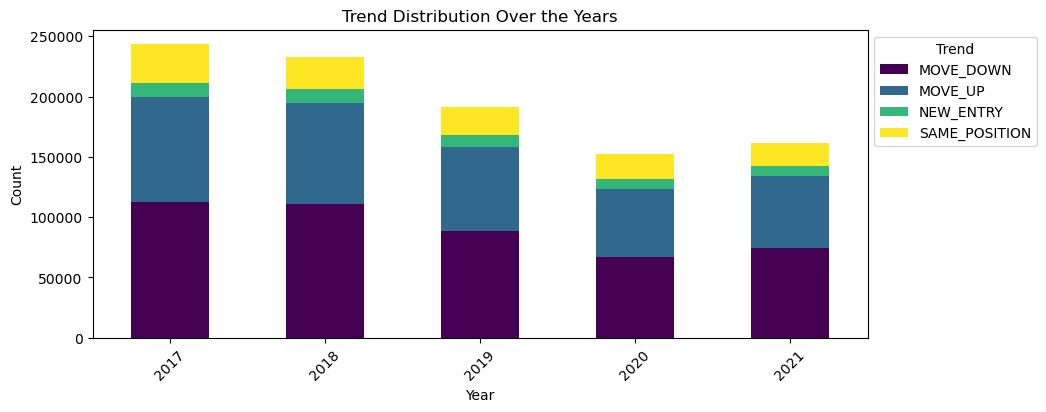

In [20]:
from pyspark.sql.functions import count
import matplotlib.pyplot as plt

# Group by Year and Trend, calculate the count of each trend
trend_counts_by_year = df.groupBy("Year", "Trend").agg(count("Trend").alias("TrendCount")).orderBy("Year", "Trend")

# Convert Spark DataFrame to Pandas for easier plotting
pandas_df = trend_counts_by_year.toPandas()

# Pivot the data for better visualization
pivoted_df = pandas_df.pivot(index="Year", columns="Trend", values="TrendCount").fillna(0)

# Plotting the trend distribution over the years
plt.figure(figsize=(10, 4))
pivoted_df.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 4))
plt.title("Trend Distribution Over the Years")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Trend", bbox_to_anchor=(1, 1))
plt.show()


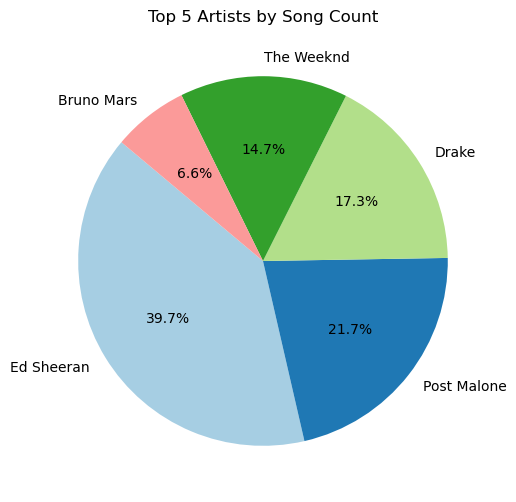

In [21]:
# Group by Artist and count the number of songs for each artist
artist_counts = df.groupBy("Artist").agg(count("*").alias("Count")).orderBy("Count", ascending=False)

# Select the top 5 artists
top_artists = artist_counts.limit(5)

# Plotting the pie chart for top artists
plt.figure(figsize=(10, 6))
plt.pie(top_artists.toPandas()["Count"], labels=top_artists.toPandas()["Artist"], autopct="%1.1f%%", startangle=140, colors=plt.cm.Paired.colors)
plt.title("Top 5 Artists by Song Count")
plt.show()

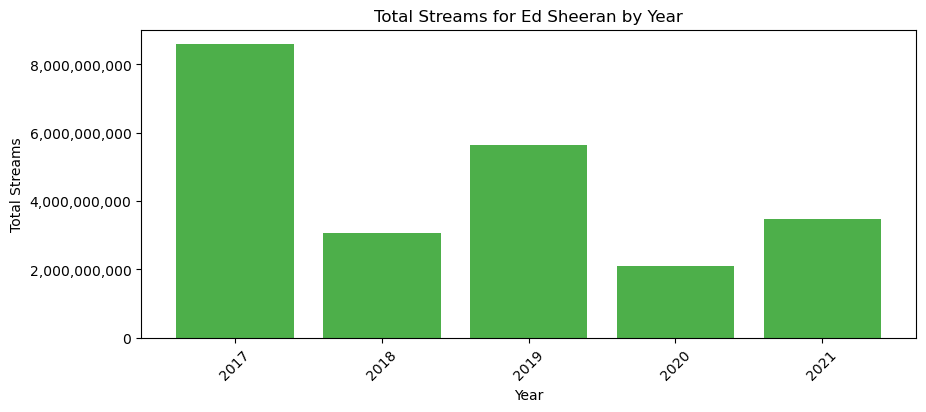

In [23]:
from matplotlib.ticker import StrMethodFormatter

specific_artist = 'Ed Sheeran'
artist_df = df.filter(col('Artist') == specific_artist)

# Grouping by 'Year' and summing the 'Stream' values
grouped_data = artist_df.groupBy('Year').agg({'Stream': 'sum'}).orderBy('Year')

# Convert PySpark DataFrame to Pandas for plotting
pandas_grouped_data = grouped_data.toPandas()

# Plotting the bar chart
plt.figure(figsize=(10, 4))
plt.bar(pandas_grouped_data['Year'], pandas_grouped_data['sum(Stream)'],color=plt.cm.Set1.colors[2])
plt.title(f'Total Streams for {specific_artist} by Year')
plt.xlabel('Year')
plt.ylabel('Total Streams')
plt.gca().get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=45)
plt.show()